# Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Open data

All data available at https://opendata-ajuntament.barcelona.cat/es/

In [2]:
!head 'data/2019_07_Juliol_BicingNou_ESTACIONS.csv.part'

"station_id","num_bikes_available","num_bikes_available_types.mechanical","num_bikes_available_types.ebike","num_docks_available","is_installed","is_renting","is_returning","last_reported","is_charging_station","status","last_updated","ttl"
1,26,25,1,0,1,1,1,"1561931759",TRUE,"IN_SERVICE",1561932001,28
2,23,23,0,0,1,1,1,"1561931805",TRUE,"IN_SERVICE",1561932001,28
3,12,12,0,13,1,1,1,"1561931771",TRUE,"IN_SERVICE",1561932001,28
4,1,1,0,18,1,1,1,"1561931940",TRUE,"IN_SERVICE",1561932001,28
5,22,22,0,15,1,1,1,"1561931919",TRUE,"IN_SERVICE",1561932001,28
6,13,13,0,23,1,1,1,"1561931850",TRUE,"IN_SERVICE",1561932001,28
7,13,13,0,11,1,1,1,"1561931996",TRUE,"IN_SERVICE",1561932001,28
8,18,18,0,8,1,1,1,"1561931904",TRUE,"IN_SERVICE",1561932001,28
9,12,12,0,10,1,1,1,"1561931936",TRUE,"IN_SERVICE",1561932001,28


In [3]:
bicing_status = pd.read_csv('data/2019_07_Juliol_BicingNou_ESTACIONS.csv.part', index_col='station_id')
bicing_status = bicing_status.drop(columns=['last_reported', 'ttl'])
bicing_status.columns = ['bikes_av', 'mechbikes_av', 'ebikes_av', 'docks_av', 'is_inst', 'is_rent', 'is_retu', 'is_char',
                       'status', 'last_updated']

/home/mlopez13/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
bicing_status.head()

,bikes_av,mechbikes_av,ebikes_av,docks_av,is_inst,is_rent,is_retu,is_char,status,last_updated
station_id,,,,,,,,,,
1,26,25,1,0,1,1,1,True,IN_SERVICE,1561932001
2,23,23,0,0,1,1,1,True,IN_SERVICE,1561932001
3,12,12,0,13,1,1,1,True,IN_SERVICE,1561932001
4,1,1,0,18,1,1,1,True,IN_SERVICE,1561932001
5,22,22,0,15,1,1,1,True,IN_SERVICE,1561932001


In [5]:
bicing_status['last_updated'].unique()

array([1561932001, 1561932278, 1561932596, ..., 1564609502, 1564609806,
       1564610089])

In [6]:
ts_list = sorted(bicing_status['last_updated'].unique())

for ts in ts_list[:3]:
    print('last updated at: ', datetime.fromtimestamp(ts))

print('...')

for ts in ts_list[-3:]:
    print('last updated at: ', datetime.fromtimestamp(ts))

last updated at:  2019-07-01 00:00:01
last updated at:  2019-07-01 00:04:38
last updated at:  2019-07-01 00:09:56
...
last updated at:  2019-07-31 23:45:02
last updated at:  2019-07-31 23:50:06
last updated at:  2019-07-31 23:54:49


Intervals of 5 minutes!!! So much information!

In [7]:
ts_diff = np.array(ts_list[1:]) - np.array(ts_list[:-1])
datetime.fromtimestamp(round(ts_diff.mean()))

datetime.datetime(1970, 1, 1, 1, 5, 38)

5 minutes, 38 seconds, in particular.

# Select data

In [8]:
bicing_status.head()

,bikes_av,mechbikes_av,ebikes_av,docks_av,is_inst,is_rent,is_retu,is_char,status,last_updated
station_id,,,,,,,,,,
1,26,25,1,0,1,1,1,True,IN_SERVICE,1561932001
2,23,23,0,0,1,1,1,True,IN_SERVICE,1561932001
3,12,12,0,13,1,1,1,True,IN_SERVICE,1561932001
4,1,1,0,18,1,1,1,True,IN_SERVICE,1561932001
5,22,22,0,15,1,1,1,True,IN_SERVICE,1561932001


In [9]:
bicing_status.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3238510 entries, 1 to 496
Data columns (total 10 columns):
bikes_av        int64
mechbikes_av    int64
ebikes_av       int64
docks_av        int64
is_inst         int64
is_rent         int64
is_retu         int64
is_char         bool
status          object
last_updated    int64
dtypes: bool(1), int64(8), object(1)
memory usage: 250.2+ MB


### Mechbikes + ebikes have to add up to all bikes available.

In [10]:
mask = bicing_status['bikes_av'] == bicing_status['mechbikes_av'] + bicing_status['ebikes_av']
bicing_status = bicing_status[mask]

In [11]:
bicing_status.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3233956 entries, 1 to 496
Data columns (total 10 columns):
bikes_av        int64
mechbikes_av    int64
ebikes_av       int64
docks_av        int64
is_inst         int64
is_rent         int64
is_retu         int64
is_char         bool
status          object
last_updated    int64
dtypes: bool(1), int64(8), object(1)
memory usage: 249.8+ MB


In [12]:
3238510-3233956

4554

### What are is_inst, is_rent, is_retu, is_char, status?

In [13]:
bicing_status['is_inst'].value_counts()

1    3220897
0      13059
Name: is_inst, dtype: int64

In [14]:
bicing_status['is_rent'].value_counts()

1    3218928
0      15028
Name: is_rent, dtype: int64

In [15]:
bicing_status['is_retu'].value_counts()

1    3218928
0      15028
Name: is_retu, dtype: int64

In [16]:
bicing_status['is_char'].value_counts()

True    3233956
Name: is_char, dtype: int64

In [17]:
bicing_status['status'].value_counts()

IN_SERVICE        3218928
PLANNED             13059
NOT_IN_SERVICE       1963
MAINTENANCE             6
Name: status, dtype: int64

Drop 'is_char', cause no info: all 'True'. Also, drop the 'PLANNED', 'NOT_IN_SERVICE' and 'MAINTENANCE' stations.

In [18]:
bicing_status = bicing_status.drop(columns=['is_char'])
bicing_status = bicing_status[bicing_status['status'] == 'IN_SERVICE']

Check the rest of columns again:

In [19]:
bicing_status['is_inst'].value_counts()

1    3218928
Name: is_inst, dtype: int64

In [20]:
bicing_status['is_rent'].value_counts()

1    3218928
Name: is_rent, dtype: int64

In [21]:
bicing_status['is_retu'].value_counts()

1    3218928
Name: is_retu, dtype: int64

In [22]:
3233956-3218928

15028

So 'is_inst', 'is_rent', 'is_retu' and 'status' can be all dropped.

In [23]:
bicing_status = bicing_status.drop(columns=['is_inst', 'is_rent', 'is_retu', 'status'])

In [24]:
bicing_status.head()

,bikes_av,mechbikes_av,ebikes_av,docks_av,last_updated
station_id,,,,,
1,26,25,1,0,1561932001
2,23,23,0,0,1561932001
3,12,12,0,13,1561932001
4,1,1,0,18,1561932001
5,22,22,0,15,1561932001


In [25]:
bicing_status.loc[1].head()

,bikes_av,mechbikes_av,ebikes_av,docks_av,last_updated
station_id,,,,,
1,26,25,1,0,1561932001
1,26,25,1,0,1561932278
1,26,25,1,0,1561932596
1,25,24,1,1,1561932874
1,26,26,0,0,1561933189


In [26]:
df1 = bicing_status.drop(columns='last_updated').groupby('station_id').mean()
df1.head()

,bikes_av,mechbikes_av,ebikes_av,docks_av
station_id,,,,
1,15.564784,15.129057,0.435727,11.266036
2,11.712125,11.324048,0.388077,12.992564
3,14.789135,14.465969,0.323166,10.998992
4,10.453890,10.135484,0.318406,8.344972
5,26.130325,25.901563,0.228762,10.569070


In [27]:
df1.describe()

,bikes_av,mechbikes_av,ebikes_av,docks_av
count,408.000000,408.000000,408.000000,408.000000
mean,10.760396,9.783984,0.976412,14.204200
std,5.703632,5.983074,0.756650,5.931125
min,1.709730,0.271695,0.156037,3.585707
25%,5.742942,4.407770,0.491965,9.489574
50%,10.153706,9.340811,0.768276,13.223936
75%,15.015755,14.482165,1.173210,18.396458
max,36.079853,34.806378,6.208276,32.347099


In [28]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408 entries, 1 to 496
Data columns (total 4 columns):
bikes_av        408 non-null float64
mechbikes_av    408 non-null float64
ebikes_av       408 non-null float64
docks_av        408 non-null float64
dtypes: float64(4)
memory usage: 15.9 KB


# Another file!!!

In [29]:
!head 'data/2019_07_Juliol_BicingNou_INFORMACIO.csv.part'

"station_id","name","physical_configuration","lat","lon","altitude","address","post_code","capacity","cross_street","last_updated","ttl"
1,"01 - C/ GRAN VIA CORTS CATALANES, 760","ELECTRICBIKESTATION","41.397952","2.180042","21","01 - C/ GRAN VIA CORTS CATALANES, 760",8908,29,NA,1561931994,21
2,"02 - C/ ROGER DE FLOR, 126","ELECTRICBIKESTATION","41.39553","2.17706","21","02 - C/ ROGER DE FLOR, 126",8908,27,NA,1561931994,21
3,"03 - C/ NÀPOLS, 82","ELECTRICBIKESTATION","41.394055","2.181299","22","03 - C/ NÀPOLS, 82",8908,27,NA,1561931994,21
4,"04 - C/ RIBES, 13","ELECTRICBIKESTATION","41.39348","2.181555","21","04 - C/ RIBES, 13",8908,20,NA,1561931994,21
5,"05 - PG. LLUIS COMPANYS, 11 (ARC TRIOMF)","ELECTRICBIKESTATION","41.391075","2.180223","16","05 - PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",8908,38,NA,1561931994,21
6,"06 - PG. LLUIS COMPANYS, 18  (ARC TRIOMF)","ELECTRICBIKESTATION","41.391349","2.18061","16","06 - PG. LLUIS COMPANYS, 18  (ARC TRIOMF)",8908,37,NA,1561931994,21
7,"07 - PG.

In [47]:
bicing_info = pd.read_csv('data/2019_07_Juliol_BicingNou_INFORMACIO.csv.part', index_col='station_id')
bicing_info = bicing_info.drop(columns=['post_code', 'ttl'])

In [31]:
bicing_info.head()

,name,physical_configuration,lat,lon,altitude,address,capacity,cross_street,last_updated
station_id,,,,,,,,,
1,"01 - C/ GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397952,2.180042,21.0,"01 - C/ GRAN VIA CORTS CATALANES, 760",29,NaN,1561931994
2,"02 - C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.395530,2.177060,21.0,"02 - C/ ROGER DE FLOR, 126",27,NaN,1561931994
3,"03 - C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.394055,2.181299,22.0,"03 - C/ NÀPOLS, 82",27,NaN,1561931994
4,"04 - C/ RIBES, 13",ELECTRICBIKESTATION,41.393480,2.181555,21.0,"04 - C/ RIBES, 13",20,NaN,1561931994
5,"05 - PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",ELECTRICBIKESTATION,41.391075,2.180223,16.0,"05 - PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",38,NaN,1561931994


# Select data.

In [32]:
bicing_info['physical_configuration'].value_counts()

ELECTRICBIKESTATION    3212011
Name: physical_configuration, dtype: int64

Can be dropped. xd

In [48]:
bicing_info = bicing_info.drop(columns='physical_configuration')

In [34]:
check = bicing_info['name'] == bicing_info['address']
np.product(check)

0

In [35]:
bicing_info[~check].head()

,name,lat,lon,altitude,address,capacity,cross_street,last_updated
station_id,,,,,,,,
37,"37 - PL. ANTONIO LÓPEZ (CORREUS, VIA LAIETANA",41.381226,2.181888,5.0,"37 - PL. ANTONIO LÓPEZ (CORREUS, VIA LAIETANA)",24,NaN,1561931994
44,"44 - AV. MERIDIANA, 66 ( COSTAT METRO GLORIES",41.402285,2.187111,18.0,"44 - AV. MERIDIANA, 66 ( COSTAT METRO GLORIES)",21,NaN,1561931994
79,79 - PL. UNIVERSITAT,41.385444,2.163430,41.0,79 - PL. UNIVERSITAT,24,NaN,1561931994
93,"93 - GRAN VIA DE LES CORTS CATALANES, 375",41.375559,2.149973,40.0,"93 - GRAN VIA DE LES CORTS CATALANES, 375-385",24,NaN,1561931994
94,"94 - GRAN VIA DE LES CORTS CATALANES, 375",41.375570,2.150068,40.0,"94 - GRAN VIA DE LES CORTS CATALANES, 375-385",24,NaN,1561931994


In [36]:
bicing_info[~check].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246874 entries, 37 to 496
Data columns (total 8 columns):
name            246874 non-null object
lat             246874 non-null float64
lon             246874 non-null float64
altitude        246874 non-null float64
address         246874 non-null object
capacity        246874 non-null int64
cross_street    0 non-null object
last_updated    246874 non-null int64
dtypes: float64(3), int64(2), object(3)
memory usage: 17.0+ MB


Let's keep address, because what i want is C, AV, PL, GV...

In [49]:
bicing_info = bicing_info.drop(columns='name')

In [38]:
bicing_info['cross_street'].value_counts()

Pg. Verdum    7917
Name: cross_street, dtype: int64

In [39]:
bicing_info.loc[1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7810 entries, 1 to 1
Data columns (total 7 columns):
lat             7810 non-null float64
lon             7810 non-null float64
altitude        7810 non-null float64
address         7810 non-null object
capacity        7810 non-null int64
cross_street    0 non-null object
last_updated    7810 non-null int64
dtypes: float64(3), int64(2), object(2)
memory usage: 488.1+ KB


Let's drop it... it's only ONE station of 400. Can't do data science with just 1 point.

In [50]:
bicing_info = bicing_info.drop(columns='cross_street')

In [41]:
bicing_info.head()

,lat,lon,altitude,address,capacity,last_updated
station_id,,,,,,
1,41.397952,2.180042,21.0,"01 - C/ GRAN VIA CORTS CATALANES, 760",29,1561931994
2,41.395530,2.177060,21.0,"02 - C/ ROGER DE FLOR, 126",27,1561931994
3,41.394055,2.181299,22.0,"03 - C/ NÀPOLS, 82",27,1561931994
4,41.393480,2.181555,21.0,"04 - C/ RIBES, 13",20,1561931994
5,41.391075,2.180223,16.0,"05 - PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",38,1561931994


In [42]:
bicing_info.loc[1].describe()

,lat,lon,altitude,capacity,last_updated
count,7.810000e+03,7.810000e+03,7810.0,7810.00000,7.810000e+03
mean,4.139795e+01,2.180042e+00,21.0,28.23790,1.563131e+09
std,4.867529e-12,4.085882e-14,0.0,0.58495,7.240003e+05
min,4.139795e+01,2.180042e+00,21.0,28.00000,1.561932e+09
25%,4.139795e+01,2.180042e+00,21.0,28.00000,1.562518e+09
50%,4.139795e+01,2.180042e+00,21.0,28.00000,1.563104e+09
75%,4.139795e+01,2.180042e+00,21.0,28.00000,1.563690e+09
max,4.139795e+01,2.180042e+00,21.0,30.00000,1.564610e+09


WATCH OUT!!!

In [43]:
bicing_info = bicing_info.reset_index().set_index(['last_updated', 'station_id']).sort_index()
bicing_info.head()

lat       lon  altitude  \
last_updated station_id                                  
1561931994   1           41.397952  2.180042      21.0   
             2           41.395530  2.177060      21.0   
             3           41.394055  2.181299      22.0   
             4           41.393480  2.181555      21.0   
             5           41.391075  2.180223      16.0   

                                                          address  capacity  
last_updated station_id                                                      
1561931994   1              01 - C/ GRAN VIA CORTS CATALANES, 760        29  
             2                         02 - C/ ROGER DE FLOR, 126        27  
             3                                 03 - C/ NÀPOLS, 82        27  
             4                                  04 - C/ RIBES, 13        20  
             5           05 - PG. LLUIS COMPANYS, 11 (ARC TRIOMF)        38

In [44]:
bicing_info.index(level=2)

TypeError: 'MultiIndex' object is not callable

In [45]:
all_stations = bicing_info.index.unique

In [51]:
df2 = bicing_info.drop(columns='last_updated').groupby('station_id').mean()
df2.head()

,lat,lon,altitude,capacity
station_id,,,,
1,41.397952,2.180042,21.0,28.237900
2,41.395530,2.177060,21.0,27.000000
3,41.394055,2.181299,22.0,27.000000
4,41.393480,2.181555,21.0,19.788313
5,41.391075,2.180223,16.0,38.077681


In [52]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408 entries, 1 to 496
Data columns (total 4 columns):
lat         408 non-null float64
lon         408 non-null float64
altitude    408 non-null float64
capacity    408 non-null float64
dtypes: float64(4)
memory usage: 15.9 KB


In [68]:
df3 = bicing_info['address'].drop_duplicates(keep='first')
df3.head()

station_id
1       01 - C/ GRAN VIA CORTS CATALANES, 760
2                  02 - C/ ROGER DE FLOR, 126
3                          03 - C/ NÀPOLS, 82
4                           04 - C/ RIBES, 13
5    05 - PG. LLUIS COMPANYS, 11 (ARC TRIOMF)
Name: address, dtype: object

In [69]:
df1 = df1.sort_index()
df2 = df2.sort_index()
df3 = df3.sort_index()

In [70]:
df = pd.concat([df1, df2, df3], axis=1)

In [72]:
df.head()

,bikes_av,mechbikes_av,ebikes_av,docks_av,lat,lon,altitude,capacity,address
station_id,,,,,,,,,
1,15.564784,15.129057,0.435727,11.266036,41.397952,2.180042,21.0,28.237900,"01 - C/ GRAN VIA CORTS CATALANES, 760"
2,11.712125,11.324048,0.388077,12.992564,41.395530,2.177060,21.0,27.000000,"02 - C/ ROGER DE FLOR, 126"
3,14.789135,14.465969,0.323166,10.998992,41.394055,2.181299,22.0,27.000000,"03 - C/ NÀPOLS, 82"
4,10.453890,10.135484,0.318406,8.344972,41.393480,2.181555,21.0,19.788313,"04 - C/ RIBES, 13"
5,26.130325,25.901563,0.228762,10.569070,41.391075,2.180223,16.0,38.077681,"05 - PG. LLUIS COMPANYS, 11 (ARC TRIOMF)"


In [93]:
x = df['capacity'] >= df['bikes_av'] + df['docks_av']
x.value_counts()

True    408
dtype: int64

# Address categories

In [73]:
df.head()

,bikes_av,mechbikes_av,ebikes_av,docks_av,lat,lon,altitude,capacity,address
station_id,,,,,,,,,
1,15.564784,15.129057,0.435727,11.266036,41.397952,2.180042,21.0,28.237900,"01 - C/ GRAN VIA CORTS CATALANES, 760"
2,11.712125,11.324048,0.388077,12.992564,41.395530,2.177060,21.0,27.000000,"02 - C/ ROGER DE FLOR, 126"
3,14.789135,14.465969,0.323166,10.998992,41.394055,2.181299,22.0,27.000000,"03 - C/ NÀPOLS, 82"
4,10.453890,10.135484,0.318406,8.344972,41.393480,2.181555,21.0,19.788313,"04 - C/ RIBES, 13"
5,26.130325,25.901563,0.228762,10.569070,41.391075,2.180223,16.0,38.077681,"05 - PG. LLUIS COMPANYS, 11 (ARC TRIOMF)"


In [74]:
df.tail()

,bikes_av,mechbikes_av,ebikes_av,docks_av,lat,lon,altitude,capacity,address
station_id,,,,,,,,,
428,12.271524,11.792008,0.479516,12.488466,41.398389,2.196261,11.0,27.000000,"428 - C/ PUJADES, 103"
492,6.520040,6.116839,0.403201,15.234686,41.394425,2.175103,21.0,24.000000,492 - PL. TETUAN
494,9.087875,8.533064,0.554811,13.686812,41.389670,2.165428,41.0,23.394450,494 - RAMBLA CATALUNYA/DIPUTACIO
495,4.903633,4.340565,0.563068,16.759839,41.376708,2.148395,45.0,22.879661,495 - C/ DIPUTACIÓ - TARRAGONA
496,6.673053,5.968238,0.704815,8.813713,41.404839,2.174820,21.0,18.000000,"496 - C/ PROVENÇA, 445"


In [75]:
mask_c = df['address'].str.contains('C/| CARRER | C ')
mask_via = df['address'].str.contains(' VIA | VÍA ')
mask_pg = df['address'].str.contains('PG.')

# square
mask_pl = df['address'].str.contains('PL.| PLAÇA ')

mask_ra = df['address'].str.contains(' RAMBL')

# wide, with trees
mask_av = df['address'].str.contains('AV.')

mask_ro = df['address'].str.contains(' RONDA ')
mask_crta = df['address'].str.contains('CRTA.')

# narrow
mask_ps = df['address'].str.contains(' PASSATGE ')

antimask = ~ ( mask_c | mask_via | mask_pg | mask_pl | mask_ra | mask_av | mask_ro | mask_crta | mask_ps )

In [76]:
np.sum(antimask)

9

In [80]:
df[antimask]

,bikes_av,mechbikes_av,ebikes_av,docks_av,lat,lon,altitude,capacity,address
station_id,,,,,,,,,
32,11.938997,11.538946,0.400050,12.304008,41.373698,2.188927,1.0,26.713149,32 - LA BARCELONETA (CN BARCELONETA)
56,16.382153,16.144316,0.237837,9.631964,41.377011,2.175834,5.0,27.000000,"56 - PORTAL DE SANTA MADRONA, 2-4"
76,5.267330,4.475548,0.791782,26.377489,41.391751,2.153123,45.0,32.000000,"76 - CÒRSEGA, 216"
221,4.231868,2.818170,1.413697,18.124084,41.402535,2.152519,71.0,24.000000,"221 - GRAN DE GRÀCIA, 155 (METRO FONTANA)"
294,2.995841,2.047391,0.948450,19.711243,41.436373,2.170678,61.0,24.000000,294 - SEU DEL DISTRICTE (NOU BARRIS)
375,8.671323,7.518820,1.152503,17.297762,41.372154,2.180701,1.0,26.732080,375 - WORLD TRADE CENTER
376,7.048275,6.187287,0.860988,19.152534,41.371663,2.180302,1.0,26.414134,376 - WORLD TRADE CENTER
389,19.402823,19.063902,0.338921,6.747794,41.387390,2.187500,11.0,27.000000,389 - RECINTE PARC DE LA CIUTADELLA
400,16.212125,15.330224,0.881901,10.961936,41.369580,2.188017,5.0,27.717570,400 - MOLL ORIENTAL


In [90]:
def add_cat(row):
    if ' VIA | VÍA ' in row['address']:
        return 'VIA'
    if 'PG.' in row['address']:
        return 'PASSEIG'
    if 'PL.| PLAÇA ' in row['address']:
        return 'PLAÇA'
    if ' RAMBL' in row['address']:
        return 'RAMBLA'
    if 'AV.' in row['address']:
        return 'AVINGUDA'
    if ' RONDA ' in row['address']:
        return 'RONDA'
    if 'CRTA.' in row['address']:
        return 'CARRETERA'
    if ' PASSATGE ' in row['address']:
        return 'PASSATGE'
    else:
        return 'CARRER'

In [91]:
df['address_cat'] = df.apply(lambda row: add_cat(row), axis=1)

In [92]:
df.head()

,bikes_av,mechbikes_av,ebikes_av,docks_av,lat,lon,altitude,capacity,address,address_cat
station_id,,,,,,,,,,
1,15.564784,15.129057,0.435727,11.266036,41.397952,2.180042,21.0,28.237900,"01 - C/ GRAN VIA CORTS CATALANES, 760",CARRER
2,11.712125,11.324048,0.388077,12.992564,41.395530,2.177060,21.0,27.000000,"02 - C/ ROGER DE FLOR, 126",CARRER
3,14.789135,14.465969,0.323166,10.998992,41.394055,2.181299,22.0,27.000000,"03 - C/ NÀPOLS, 82",CARRER
4,10.453890,10.135484,0.318406,8.344972,41.393480,2.181555,21.0,19.788313,"04 - C/ RIBES, 13",CARRER
5,26.130325,25.901563,0.228762,10.569070,41.391075,2.180223,16.0,38.077681,"05 - PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",PASSEIG


# LINEAR REGRESSION

In [94]:
def linreg(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    reg = LinearRegression()
    reg.fit(X_train, y_train)

    pred = reg.predict(X_test)

    print('Intercept:', reg.intercept_)
    print('Coefficients:\n', reg.coef_)
    print('Mean squared error: ', mean_squared_error(y_test, pred))
    print('r2 score: ', r2_score(y_test, pred))
    print('r2 score (train): ', r2_score(y_train, reg.predict(X_train)))

    lim = max(max(pred), max(y_test))
    
    # plot
    plt.figure(figsize=(6, 6))

    plt.scatter(pred, y_test, marker='+', color='red')
    plt.plot([0, lim], [0, lim], linewidth=1, color='blue')
    plt.title('Linear regression: bikes_av')
    plt.xlabel('prediction')
    plt.ylabel('truth')
    plt.xlim([0, lim])
    plt.ylim([0, lim])
    plt.grid()

    plt.show()

In [95]:
X = df[['lat', 'lon', 'altitude']]
y = df['bikes_av']

Intercept: 2759.3535918873504
Coefficients:
 [-7.12209939e+01  9.29410434e+01 -5.75482854e-02]
Mean squared error:  18.39409775072902
r2 score:  0.41874357960887676
r2 score (train):  0.37574606191246007


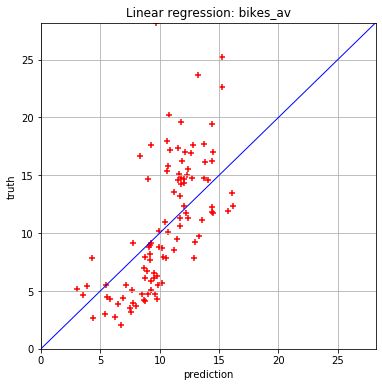

In [96]:
linreg(X, y)

In [98]:
df['lat2'] = (df['lat'] - df['lat'].mean())**2
df['lon2'] = (df['lon'] - df['lon'].mean())**2

In [99]:
X = df[['lat2', 'lon2', 'altitude']]
y = df['bikes_av']

Intercept: 14.545292674748445
Coefficients:
 [ 1.00274675e+03  5.96110785e+02 -1.30797786e-01]
Mean squared error:  24.11881696344354
r2 score:  0.30095767960130204
r2 score (train):  0.3701291812777584


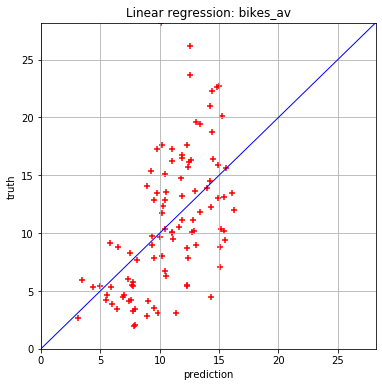

In [100]:
linreg(X, y)

In [101]:
X = df[['altitude']]
y = df['bikes_av']

Intercept: 15.49239436302892
Coefficients:
 [-0.13106383]
Mean squared error:  20.31717239755324
r2 score:  0.30655740411538457
r2 score (train):  0.3419709720795505


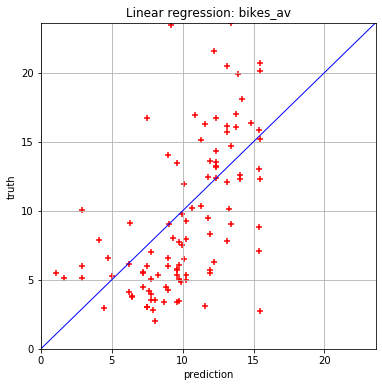

In [102]:
linreg(X, y)

# OLD STUFF

To start, I can take data from July 1st, which was a monday. To keep it simpler, I will take information of each hour interval.

In [36]:
ts_list = bicing_status['last_updated'].unique()
chosen = []

h = 0
for ts in ts_list:
    dt = datetime.fromtimestamp(ts)
    if (dt.day == 1) & (dt.hour == h):
        chosen.append(ts)
        h += 1

In [37]:
mask = bicing_status['last_updated'].isin(chosen)

In [38]:
bicing_status = bicing_status[mask]

In [39]:
bicing_status.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9792 entries, 1 to 496
Data columns (total 10 columns):
bikes_av        9792 non-null int64
mechbikes       9792 non-null int64
ebikes          9792 non-null int64
docks_av        9792 non-null int64
is_inst         9792 non-null int64
is_rent         9792 non-null int64
is_retu         9792 non-null int64
is_char         9792 non-null bool
status          9792 non-null object
last_updated    9792 non-null int64
dtypes: bool(1), int64(8), object(1)
memory usage: 774.6+ KB


In [56]:
bicing_info = pd.read_csv('2019_07_Juliol_BicingNou_INFORMACIO.csv.part',
                          usecols=['station_id', 'lat', 'lon', 'alt', 'capacity', 'last_updated'],
                          index_col='station_id')
#bicing_info = bicing_info[bicing_info['last_updated'] == max(bicing_info['last_updated'])]

In [59]:
bicing_info.head()

,lat,lon,altitude,capacity,last_updated
station_id,,,,,
1,41.397952,2.180042,21.0,30,1564610090
2,41.395530,2.177060,21.0,27,1564610090
3,41.394055,2.181299,22.0,27,1564610090
4,41.393480,2.181555,21.0,20,1564610090
5,41.391075,2.180223,16.0,38,1564610090


In [63]:
print('bicing_status: ', datetime.fromtimestamp(1564610089))
print('bicing_info: ', datetime.fromtimestamp(1564610090))

bicing_esta:  2019-07-31 23:54:49
bicing_info:  2019-07-31 23:54:50


Same time. Can be dropped too.

In [64]:
bicing_status = bicing_status.drop('last_updated', axis=1)
bicing_info = bicing_info.drop('last_updated', axis=1)

In [75]:
x = bicing_status.index == bicing_info.index

# if all values in x are True, then all values in ~x are False, hence the any function will return False:
any(~x)

False

In [77]:
bicing = pd.concat([bicing_status, bicing_info], axis=1)
bicing.head()

,bikes_av,mechbikes,ebikes,docks_av,lat,lon,altitude,capacity
station_id,,,,,,,,
1,21,21,0,8,41.397952,2.180042,21.0,30
2,3,3,0,24,41.395530,2.177060,21.0,27
3,22,22,0,4,41.394055,2.181299,22.0,27
4,7,7,0,13,41.393480,2.181555,21.0,20
5,30,29,1,4,41.391075,2.180223,16.0,38


In [80]:
x = bicing['capacity'] >= bicing['bikes_av'] + bicing['docks_av']
x.value_counts()

True    407
dtype: int64

According to https://www.bicing.barcelona/mapa-de-disponibilitat-provisional, there are 424 bicing stations. To study 407 of them is enough.

In [70]:
min(bicing['capacity'])

14

In [71]:
max(bicing['capacity'])

54

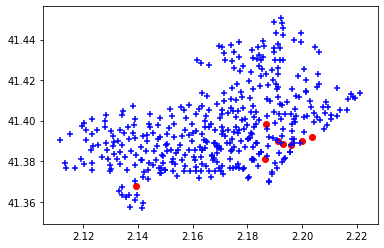

In [81]:
mask = bicing['capacity'] >= 40

X = bicing[mask]['lon']
Y = bicing[mask]['lat']
x = bicing[~mask]['lon']
y = bicing[~mask]['lat']

plt.scatter(X, Y, color='red', marker='o')
plt.scatter(x, y, color='blue', marker='+')
plt.show()

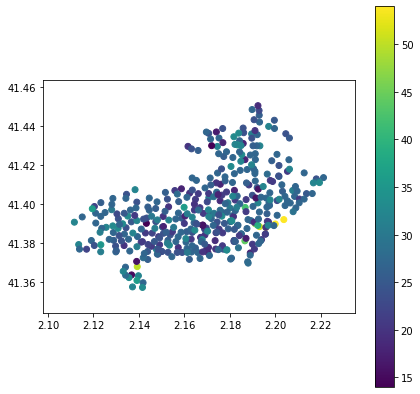

In [82]:
x = bicing['lon']
y = bicing['lat']
z = bicing['capacity']

aspect = (max(y) - min(y))/(max(x) - min(x))

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect(aspect)

plt.scatter(x, y, c=z, marker='o')
plt.colorbar()
plt.show()

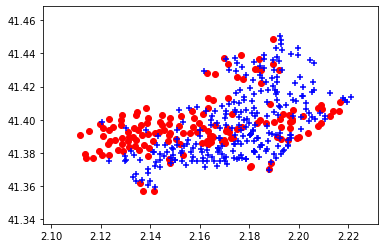

In [84]:
mask = bicing['docks_av'] >= 20

X = bicing[mask]['lon']
Y = bicing[mask]['lat']
x = bicing[~mask]['lon']
y = bicing[~mask]['lat']

plt.scatter(X, Y, color='red', marker='o')
plt.scatter(x, y, color='blue', marker='+')
plt.show()

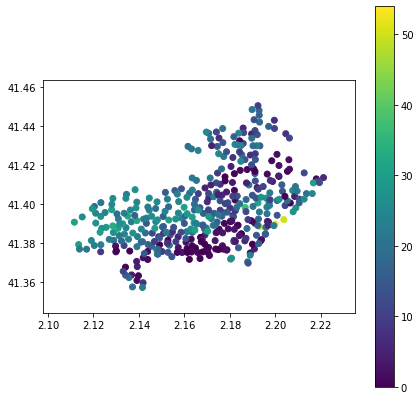

In [85]:
x = bicing['lon']
y = bicing['lat']
z = bicing['docks_av']

aspect = (max(y) - min(y))/(max(x) - min(x))

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect(aspect)

plt.scatter(x, y, c=z, marker='o')
plt.colorbar()
plt.show()

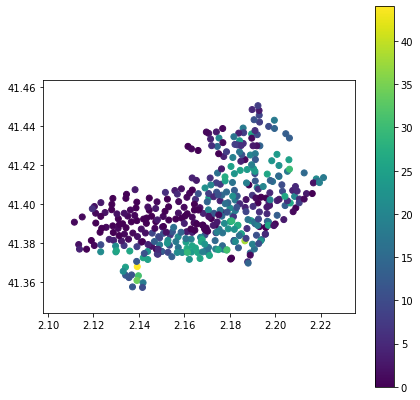

In [86]:
x = bicing['lon']
y = bicing['lat']
z = bicing['bikes_av']

aspect = (max(y) - min(y))/(max(x) - min(x))

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect(aspect)

plt.scatter(x, y, c=z, marker='o')
plt.colorbar()
plt.show()

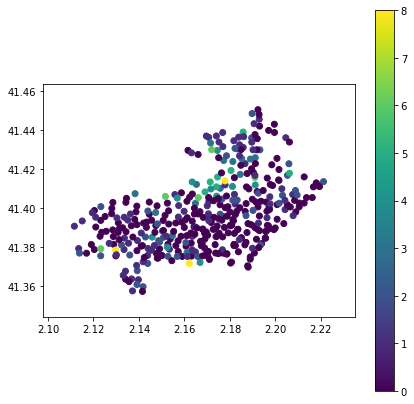

In [89]:
x = bicing['lon']
y = bicing['lat']
z = bicing['ebikes']

aspect = (max(y) - min(y))/(max(x) - min(x))

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect(aspect)

plt.scatter(x, y, c=z, marker='o')
plt.colorbar()
plt.show()

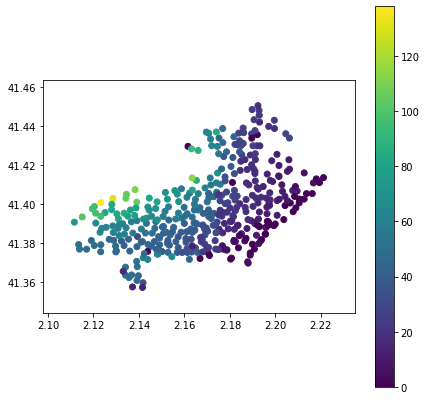

In [90]:
x = bicing['lon']
y = bicing['lat']
z = bicing['altitude']

aspect = (max(y) - min(y))/(max(x) - min(x))

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect(aspect)

plt.scatter(x, y, c=z, marker='o')
plt.colorbar()
plt.show()

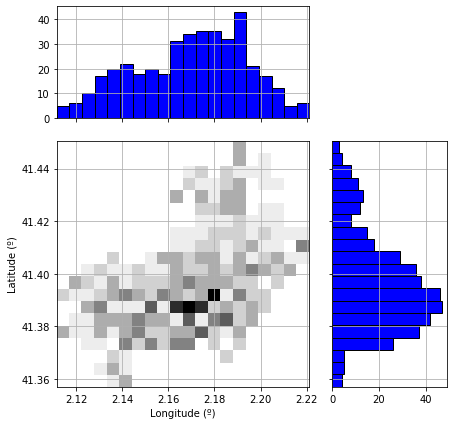

In [83]:
x = bicing['lon']
y = bicing['lat']

fig = plt.figure(figsize=(7, 7))
gspec = gridspec.GridSpec(3, 3)

histo = fig.add_subplot(gspec[1:, 0:-1])
top_histo = fig.add_subplot(gspec[0, 0:-1])
right_histo = fig.add_subplot(gspec[1:, -1])

histo.hist2d(x, y, bins=20, cmap='Greys')
histo.set_xlabel('Longitude (º)')
histo.set_ylabel('Latitude (º)')
histo.grid()

top_histo.hist(x, bins=20, color='blue', edgecolor='black')
top_histo.set_xlim([min(x), max(x)])
top_histo.set_xticklabels([])
top_histo.grid()

right_histo.hist(y, bins=20, color='blue', edgecolor='black', orientation='horizontal')
right_histo.set_ylim([min(y), max(y)])
right_histo.set_yticklabels([])
right_histo.grid()

#histo.colorbar()
plt.show()

In [14]:
x = bicing['lon']
y = bicing['lat']

lonlat, xedg, yedg = np.histogram2d(x, y, bins=20)
lonlat = lonlat.T

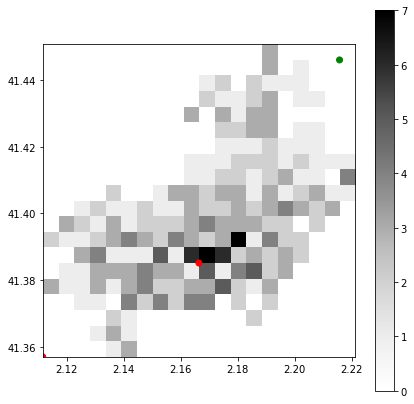

In [15]:
extent = xedg[0], xedg[-1], yedg[0], yedg[-1]
aspect = (xedg[-1] - xedg[0])/(yedg[-1] - yedg[0])

plt.figure(figsize=(7, 7))
plt.scatter([xedg[0], xedg[10], xedg[19]], [yedg[0], yedg[6], yedg[19]], color=['red', 'red', 'green'])
plt.imshow(lonlat, origin='low', cmap='Greys', extent=extent, aspect=aspect)
plt.colorbar()
plt.show()

In [16]:
lonlat[6, 10]

7.0

In [17]:
lonlat[7, 12]

7.0

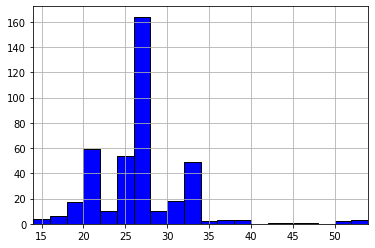

In [18]:
z = bicing['capacity']

plt.xlim([min(z), max(z)])
plt.hist(z, bins=20, color='blue', edgecolor='black')

plt.grid()